# Part 1: Data
Create synthetic multi-variate Gaussian data using parameters I chose

In [674]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [691]:
m = 1
n = 100
d = 1
w = [1, 3]
μ = [-9, 4]
σ = [1, 2]


In [692]:
def generate_mixture_of_gaussians(n_samples, means, stds, weights):
    n_components = len(means)
    assert len(stds) == n_components and len(weights) == n_components
    data = []
    for _ in range(n_samples):
        component = np.random.choice(n_components, p=weights)
        sample = np.random.normal(means[component], stds[component])
        data.append([sample])
    return torch.tensor(data)

In [693]:
data = generate_mixture_of_gaussians(n, μ, σ, w/np.sum(w))

In [694]:
data[:10]

tensor([[ 3.9615],
        [ 2.4874],
        [-0.1904],
        [ 6.1698],
        [ 6.2873],
        [ 4.0870],
        [-8.5048],
        [-8.5909],
        [ 4.5359],
        [ 3.2918]])

In [695]:
print(data[:10])
print(data.shape)

tensor([[ 3.9615],
        [ 2.4874],
        [-0.1904],
        [ 6.1698],
        [ 6.2873],
        [ 4.0870],
        [-8.5048],
        [-8.5909],
        [ 4.5359],
        [ 3.2918]])
torch.Size([100, 1])


In [696]:
train_dataloader = DataLoader(data, batch_size=64, shuffle=True)

# Part 2: Models

## Part 2.1: VAE

## Part 2.2: Score Matching
Match scores with a NN with loss
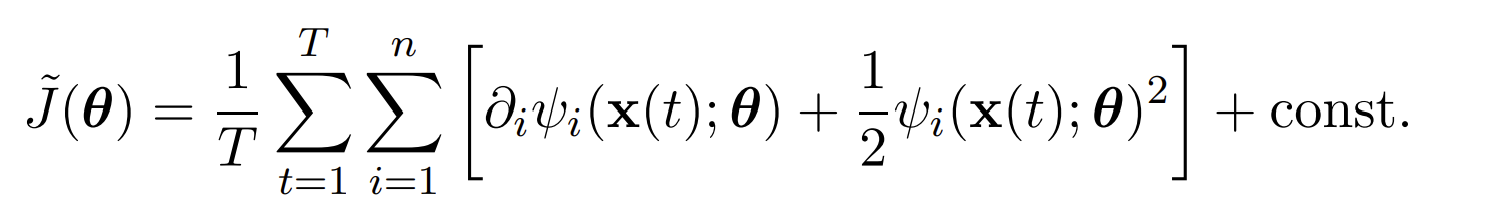 
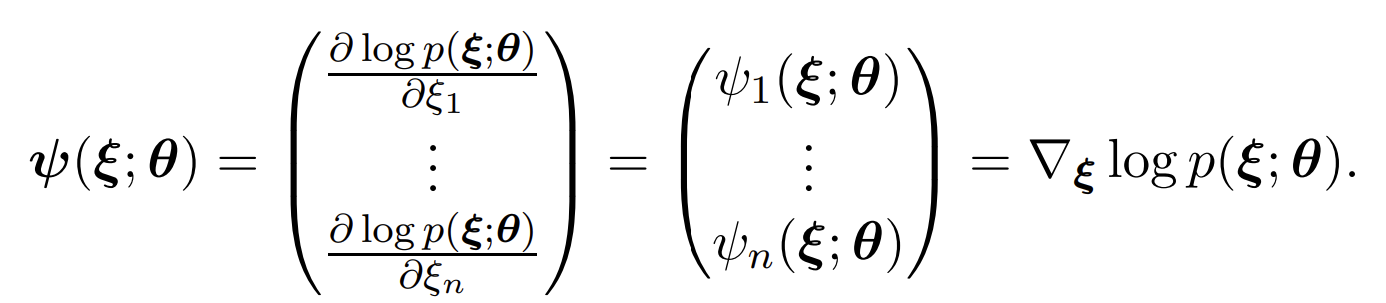

### Part 2.21: Model

In [697]:
def score_matching_loss(model, X):
    loss = None
    for x in X:
        x.requires_grad_(True)
        logp = torch.log(model(x))
        logp.requires_grad_(True)
        ψ = torch.autograd.grad(logp, x, create_graph=True)[0][0]
        ψ.requires_grad_(True)
        ψ2 = torch.autograd.grad(ψ, x, create_graph=True, retain_graph=True)[0][0]
        if loss is None:
            loss = ψ2 + .5 * ψ * ψ
        else:
            loss += ψ2 + .5 * ψ * ψ
    return loss

epoch = 0, loss = 0.0002


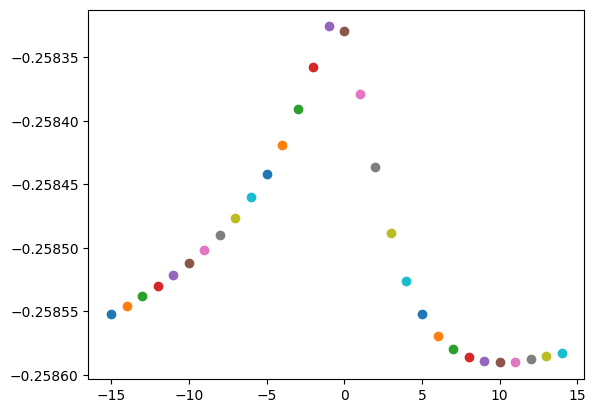

epoch = 10, loss = -0.0018


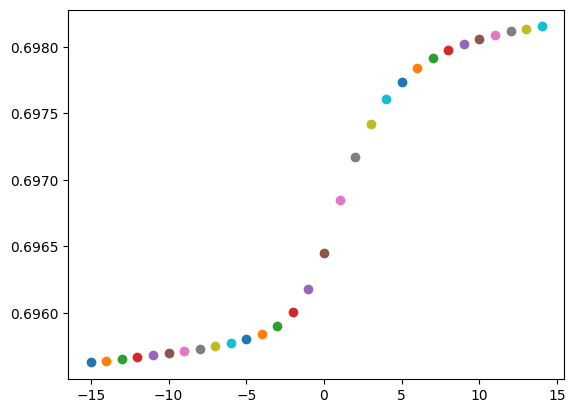

epoch = 20, loss = -0.0297


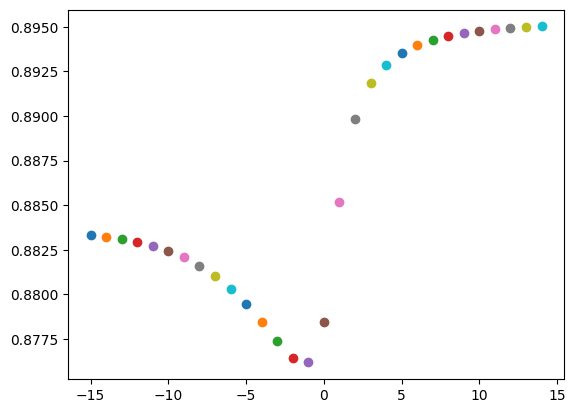

epoch = 30, loss = -1.4368


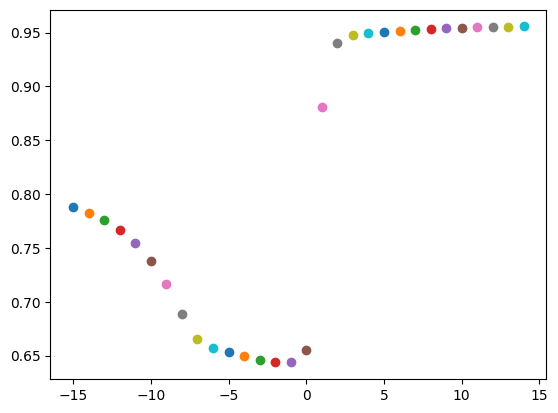

epoch = 40, loss = -1.1505


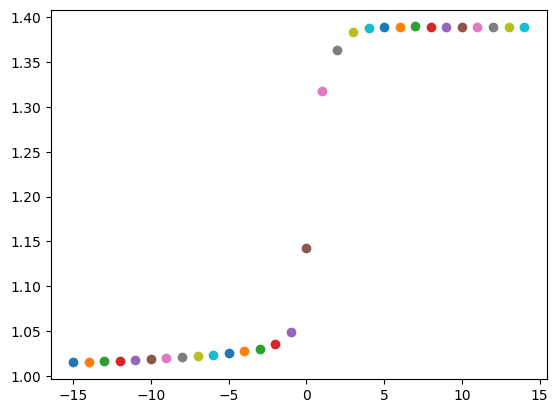

epoch = 50, loss = -1.2778


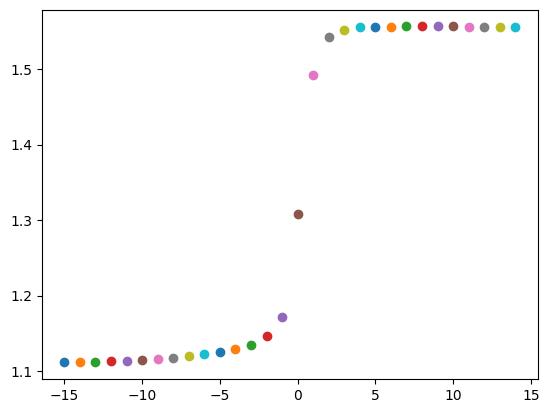

epoch = 60, loss = -1.5631


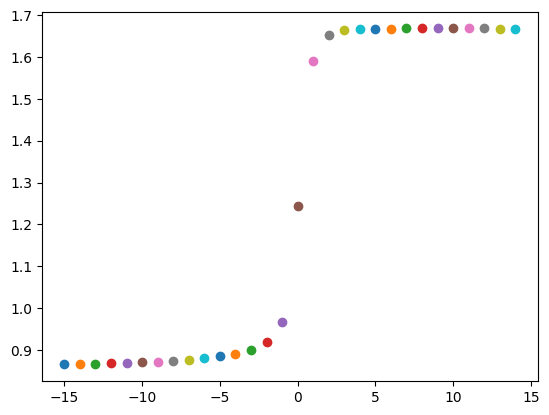

epoch = 70, loss = -2.0982


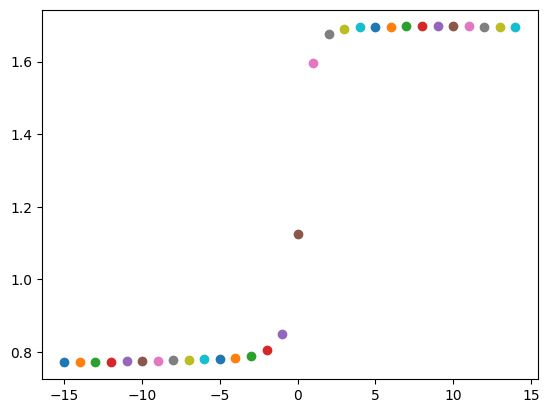

epoch = 80, loss = -0.9144


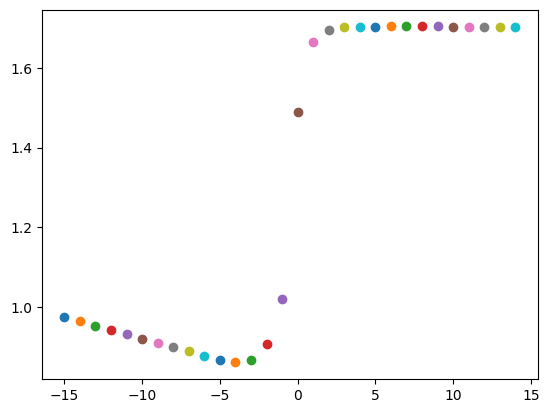

epoch = 90, loss = -0.7696


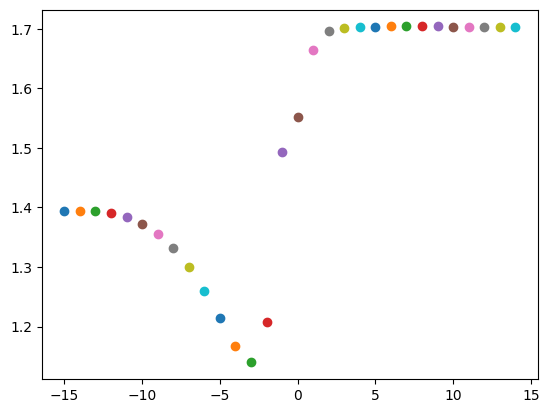

In [733]:
class ScoreMatcher(nn.Module):
    def __init__(self):
        super(ScoreMatcher, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, d),
        )

    def forward(self, x):
        return self.net(x)

model = ScoreMatcher()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

opt = (2000, None)
for epoch in range(num_epochs):
    avg_loss = 0
    for X in train_dataloader:
        output = model(X)
        loss = score_matching_loss(model, X)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss /= len(train_dataloader)
    opt = min(opt, (avg_loss, model))
    if epoch%10==0:
        print(f'epoch = {epoch}, loss = {avg_loss:.4f}')
        for v in range(-15, 15, 1):
            # print(v, float(model(torch.tensor([float(v)]))))
            plt.scatter(v, float(model(torch.tensor([float(v)]))))
        plt.show()


In [681]:
def score_matching_loss(model, X):
    loss = None
    for x in X:
        # print(x.shape)
        x.requires_grad_(True)
        # print("y assert > 0", model(x))
        logp = torch.log(model(x))
        logp.requires_grad_(True)
        # print(torch.autograd.grad(logp, x, create_graph=True))
        ψ = torch.autograd.grad(logp, x, create_graph=True)[0][0]
        # print("psi", ψ)
        # print(type(ψ))
        ψ.requires_grad_(True)
        # print("params", model.μ, model.σ)
        ψ2 = torch.autograd.grad(ψ, x, create_graph=True, retain_graph=True)[0][0]
        # print("x", x, "logp", logp, "ψ", ψ, "ψ2", ψ2)
        if loss is None:
            loss = ψ2 + .5 * ψ * ψ
        else:
            loss += ψ2 + .5 * ψ * ψ
    # print("output loss", loss)
    return loss

In [1]:
class GaussianModel(nn.Module):
    def __init__(self):
        super(GaussianModel, self).__init__()
        self.μ = nn.Parameter(torch.tensor([0.]))
        self.σ = nn.Parameter(torch.tensor([100.]))

    def forward(self, x):
        return torch.exp(-.5 * (x - self.μ) ** 2 / self.σ ** 2) / (self.σ * sqrt(2 * np.pi))

NameError: name 'nn' is not defined

epoch = 0, loss = -0.0066276456


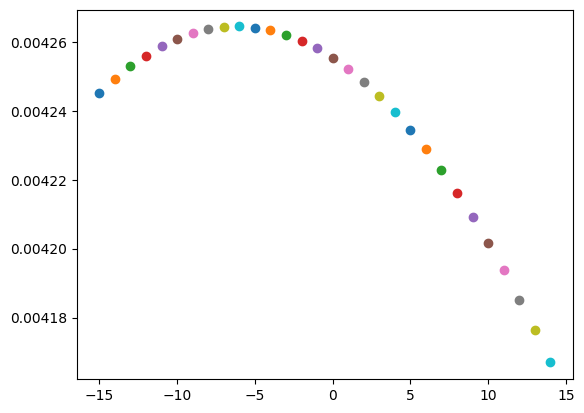

epoch = 5, loss = -0.0190032440


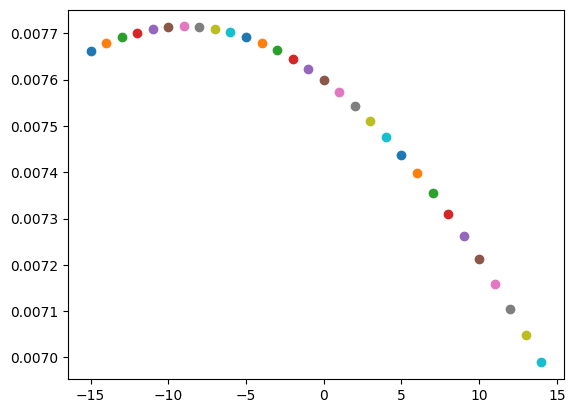

epoch = 10, loss = -7.8727056980


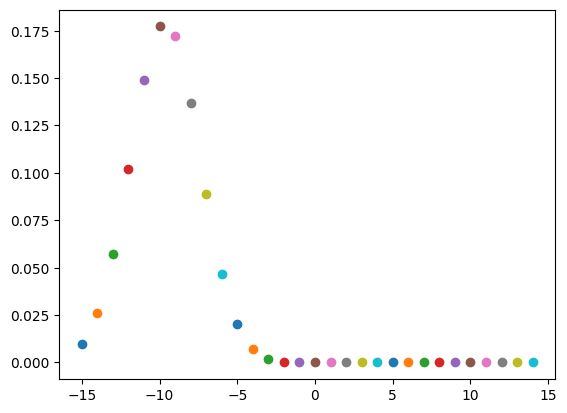

epoch = 15, loss = -3.2413922548


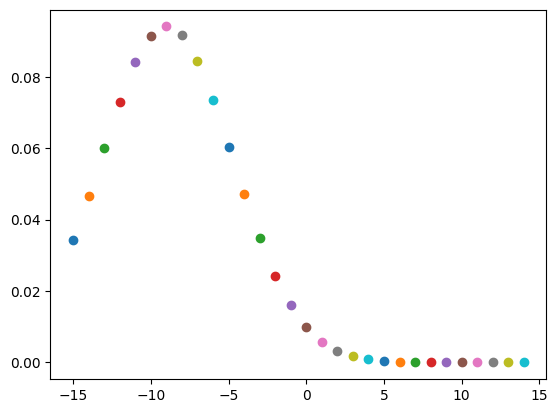

epoch = 20, loss = -7.3291319311


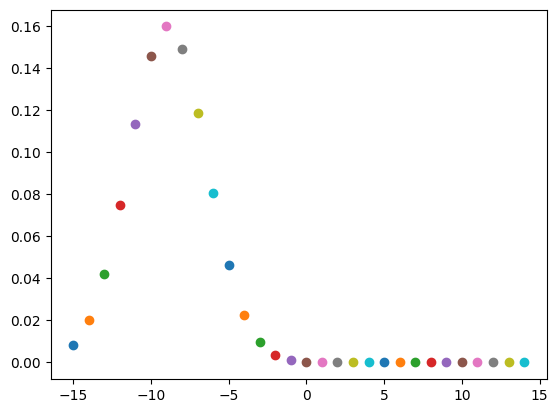

epoch = 25, loss = -27.4805200100


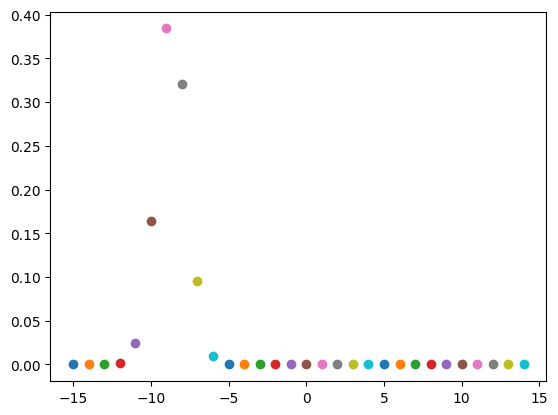

epoch = 30, loss = -30.5924074650


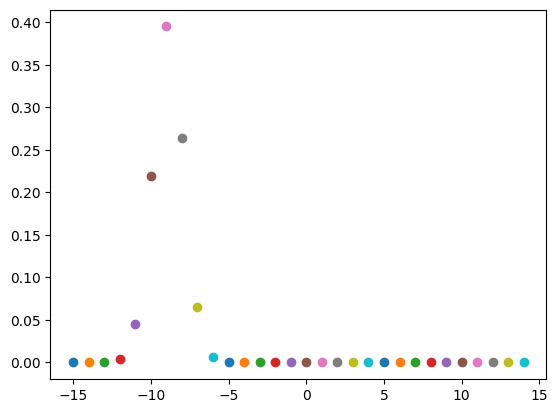

epoch = 35, loss = -29.1177549958


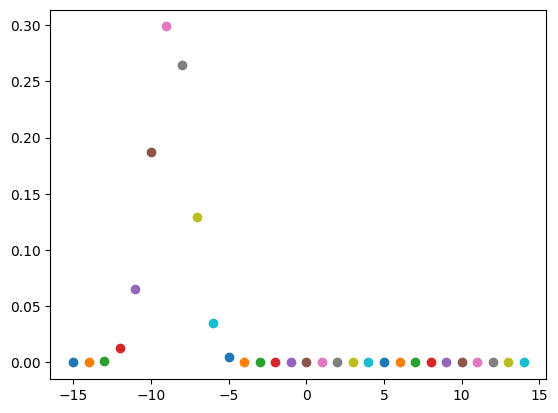

epoch = 40, loss = -29.8955826759


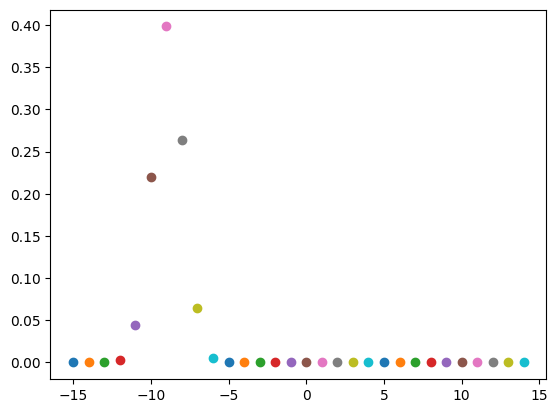

KeyboardInterrupt: 

In [688]:
model = GaussianModel()

num_epochs = 100

optimizer = optim.Adam(model.parameters(), lr=.4)
for epoch in range(num_epochs):
    avg_loss = 0
    for X in train_dataloader:
        # print(model.μ, model.σ)
        # loss = nn.MSELoss()(model(X), torch.ones_like(X))
        loss = score_matching_loss(model, X)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("loss", loss)
    avg_loss /= len(train_dataloader)
    if epoch%5==0:
        print(f'epoch = {epoch}, loss = {avg_loss:.10f}')
        for v in range(-15, 15, 1):
            plt.scatter(v, float(model(torch.tensor([float(v)]))))
        plt.show()


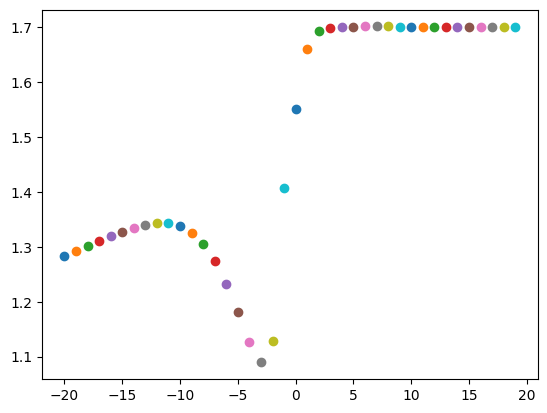

In [738]:
for v in range(-20, 20, 1):
    # print(v, float(model(torch.tensor([float(v)]))))
    plt.scatter(v, float(model_opt(torch.tensor([float(v)]))))
plt.show()

In [363]:
model.mu

0

### Part 2.22: Sample

In [735]:
step_size = 0.01
num_steps = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [736]:
def sample_langevin_dynamics(model, n):
    X = torch.randn(n, d)
    for _ in range(num_steps):
        X.requires_grad_(True)
        scores = model(X)
        # print(scores[:10])
        grad = torch.autograd.grad(scores, X, grad_outputs=torch.ones_like(scores))[0]
        # print(grad)
        X = X + step_size  * grad + torch.randn(n, d) * sqrt(2 * step_size)
        X = X.detach()
    return X

(array([  1.,   0.,   1.,   5.,  17.,  26.,  35.,  86., 139., 160., 164.,
        136.,  99.,  61.,  43.,  14.,  10.,   3.]),
 array([-6.96266556, -6.27156687, -5.58046818, -4.88936949, -4.1982708 ,
        -3.50717187, -2.81607318, -2.12497425, -1.43387556, -0.74277687,
        -0.05167813,  0.63942063,  1.33051932,  2.02161813,  2.71271682,
         3.40381551,  4.09491444,  4.78601313,  5.47711182]),
 <BarContainer object of 18 artists>)

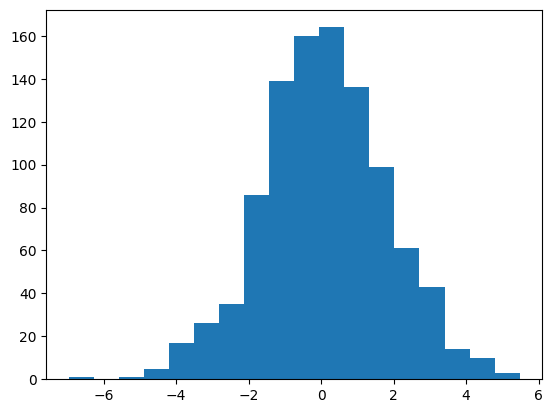

In [737]:
model_opt = opt[1]
sm_data = sample_langevin_dynamics(model_opt, 1000).detach()
plt.hist(sm_data.squeeze(1), bins=18)

(array([ 2., 10., 14.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  6.,  6.,
         9., 11., 13., 15.,  6.,  1.,  1.]),
 array([-11.36595726, -10.32321739,  -9.28047657,  -8.2377367 ,
         -7.19499588,  -6.15225601,  -5.10951567,  -4.06677532,
         -3.02403498,  -1.98129463,  -0.93855429,   0.10418601,
          1.14692628,   2.18966651,   3.23240685,   4.27514744,
          5.31788731,   6.36062765,   7.403368  ,   8.44610882,
          9.48884869]),
 <BarContainer object of 20 artists>)

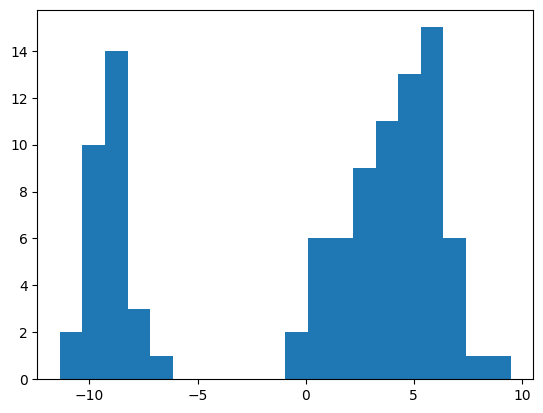

In [706]:
plt.hist(data.squeeze(1), bins=20)